<a href="https://colab.research.google.com/github/Fragoa/Image-Denoising-with-AE/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Phase 1: Data Preparation

In [10]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

base_train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
base_test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [11]:
train_size = int(0.7 * len(base_train_dataset))
val_size = len(base_train_dataset) - train_size
train_data, val_data = random_split(base_train_dataset, [train_size, val_size])

In [3]:
def add_gaussian_noise(img, mean=0., std=0.2):
    noisy = img + torch.randn_like(img) * std
    return torch.clamp(noisy, 0., 1.)

In [4]:
def add_salt_pepper_noise(img, amount=0.05):
    noisy = img.clone()
    num_salt = int(amount * img.numel() * 0.5)
    num_pepper = int(amount * img.numel() * 0.5)
    coords_salt = torch.randint(0, img.numel(), (num_salt,))
    coords_pepper = torch.randint(0, img.numel(), (num_pepper,))
    flat = noisy.view(-1)
    flat[coords_salt] = 1
    flat[coords_pepper] = 0
    return noisy

In [5]:
class NoisyMNIST(Dataset):
    def __init__(self, dataset, noise_type="gaussian"):
        self.dataset = dataset
        self.noise_type = noise_type

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        if self.noise_type == "gaussian":
            noisy = add_gaussian_noise(img)
        else:
            noisy = add_salt_pepper_noise(img)
        return noisy, img  # (input, target)

In [12]:
train_dataset = NoisyMNIST(train_data)
val_dataset = NoisyMNIST(val_data)
test_dataset = NoisyMNIST(base_test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

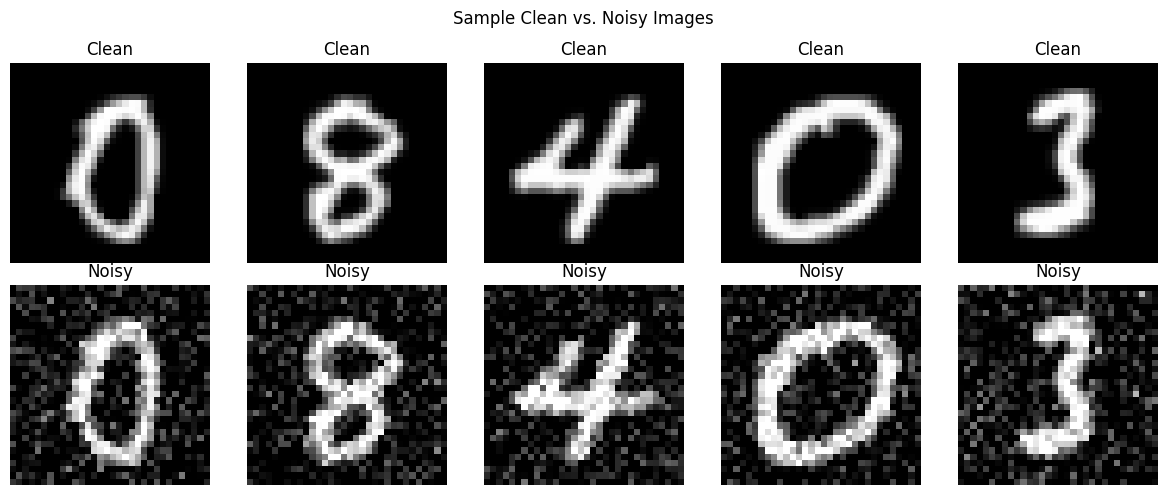

In [13]:
noisy_sample, clean_sample = next(iter(train_loader))
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    axes[0, i].imshow(clean_sample[i][0], cmap="gray")
    axes[0, i].set_title("Clean")
    axes[0, i].axis("off")
    axes[1, i].imshow(noisy_sample[i][0], cmap="gray")
    axes[1, i].set_title("Noisy")
    axes[1, i].axis("off")
plt.suptitle("Sample Clean vs. Noisy Images")
plt.tight_layout()
plt.show()

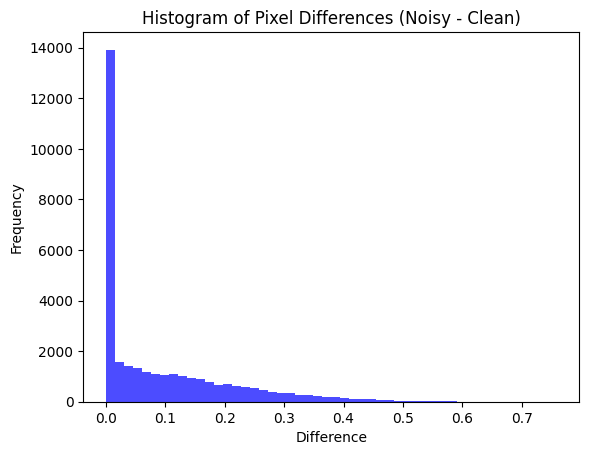

In [14]:
diff = (noisy_sample - clean_sample).abs().view(-1).numpy()
plt.hist(diff, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Pixel Differences (Noisy - Clean)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show()

# Phase 2: Autoencoder Model

In [7]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(), nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
model = ConvAE()
print(model)

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
def train(model, train_loader, val_loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for noisy, clean in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            loss = criterion(output, clean)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)
                output = model(noisy)
                loss = criterion(output, clean)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

Epoch 1/10, Train Loss: 0.0190, Val Loss: 0.0038
Epoch 2/10, Train Loss: 0.0037, Val Loss: 0.0030
Epoch 3/10, Train Loss: 0.0031, Val Loss: 0.0027
Epoch 4/10, Train Loss: 0.0029, Val Loss: 0.0025
Epoch 5/10, Train Loss: 0.0027, Val Loss: 0.0024
Epoch 6/10, Train Loss: 0.0026, Val Loss: 0.0024
Epoch 7/10, Train Loss: 0.0025, Val Loss: 0.0023
Epoch 8/10, Train Loss: 0.0024, Val Loss: 0.0022
Epoch 9/10, Train Loss: 0.0023, Val Loss: 0.0022
Epoch 10/10, Train Loss: 0.0023, Val Loss: 0.0022


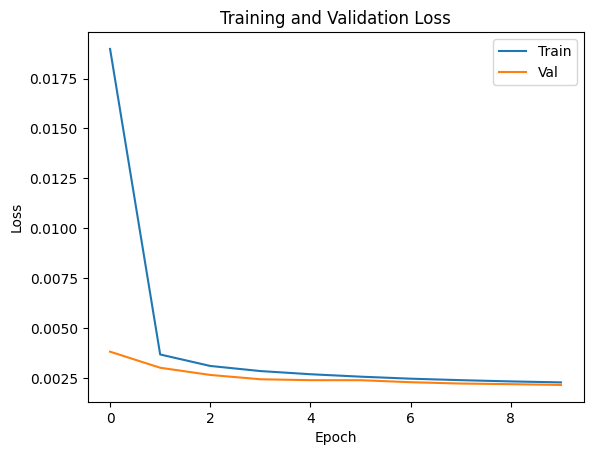

In [17]:
train_losses, val_losses = train(model, train_loader, val_loader, epochs=10)

# Plot Loss Curves
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/10, Train Loss: 0.0151, Val Loss: 0.0036
Epoch 2/10, Train Loss: 0.0036, Val Loss: 0.0029
Epoch 3/10, Train Loss: 0.0031, Val Loss: 0.0026
Epoch 4/10, Train Loss: 0.0028, Val Loss: 0.0025
Epoch 5/10, Train Loss: 0.0027, Val Loss: 0.0026
Epoch 6/10, Train Loss: 0.0026, Val Loss: 0.0023
Epoch 7/10, Train Loss: 0.0025, Val Loss: 0.0023
Epoch 8/10, Train Loss: 0.0024, Val Loss: 0.0022
Epoch 9/10, Train Loss: 0.0023, Val Loss: 0.0021
Epoch 10/10, Train Loss: 0.0023, Val Loss: 0.0021


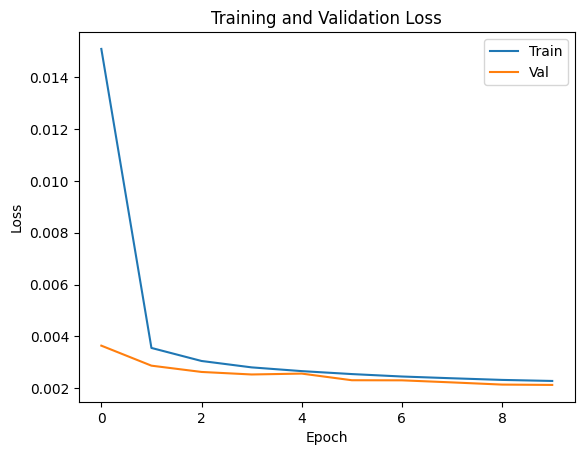

In [9]:
model = ConvAE()
train_losses, val_losses = train(model, train_loader, val_loader, epochs=10)

# Plot Loss Curves
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [18]:
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    psnr_list, ssim_list, mse_list = [], [], []
    with torch.no_grad():
        for noisy, clean in test_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            for i in range(noisy.size(0)):
                clean_img = clean[i].cpu().numpy().squeeze()
                output_img = output[i].cpu().numpy().squeeze()
                mse_val = np.mean((output_img - clean_img) ** 2)
                psnr_val = psnr(clean_img, output_img, data_range=1)
                ssim_val = ssim(clean_img, output_img, data_range=1)
                mse_list.append(mse_val)
                psnr_list.append(psnr_val)
                ssim_list.append(ssim_val)
    print("\n--- Test Metrics ---")
    print(f"MSE:  {np.mean(mse_list):.4f}")
    print(f"PSNR: {np.mean(psnr_list):.2f} dB")
    print(f"SSIM: {np.mean(ssim_list):.4f}")

evaluate(model, test_loader)


--- Test Metrics ---
MSE:  0.0021
PSNR: 26.98 dB
SSIM: 0.9434


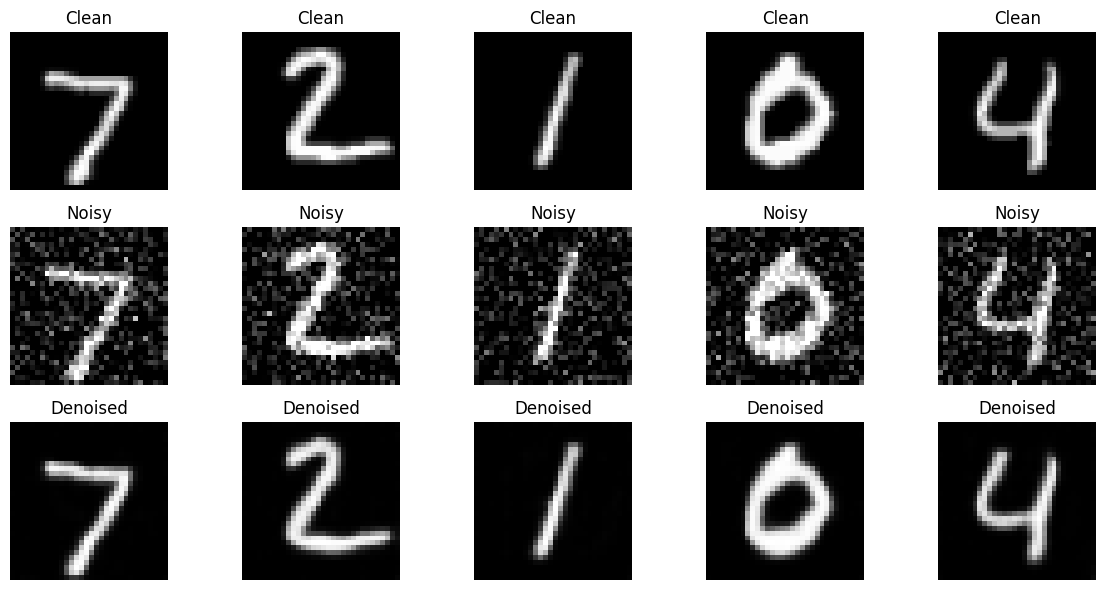

In [19]:
model.eval()
noisy_sample, clean_sample = next(iter(test_loader))
with torch.no_grad():
    output_sample = model(noisy_sample.cuda() if torch.cuda.is_available() else noisy_sample)

fig, axes = plt.subplots(3, 5, figsize=(12, 6))
for i in range(5):
    axes[0, i].imshow(clean_sample[i][0], cmap="gray")
    axes[0, i].set_title("Clean")
    axes[1, i].imshow(noisy_sample[i][0], cmap="gray")
    axes[1, i].set_title("Noisy")
    axes[2, i].imshow(output_sample[i][0].cpu(), cmap="gray")
    axes[2, i].set_title("Denoised")
    for j in range(3):
        axes[j, i].axis("off")
plt.tight_layout()
plt.show()